In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

### Search engine comparison

In [3]:
def position_weight(k: int, method="log"):
    if method == "log":
        return 1 / np.log2(k + 1)
    elif method == "linear":
        return 1 / k
    else:
        raise ValueError("Unknown weighting method")


def relevance(val):
    """
    val ∈ {1, 0.5, 0}
    """
    if val <= 0 or pd.isna(val):
        return 0.0
    return float(val)


def ranked_scores(row, cols, relevance_fn, weight_method="log", **relevance_kwargs):
    score_vals = []
    coverage_vals = []

    for i, col in enumerate(cols, start=1):
        rel = relevance_fn(row[col], **relevance_kwargs)

        if rel <= 0:
            continue

        w = position_weight(i, weight_method)

        score_vals.append(rel * w)
        coverage_vals.append(w)

    score = max(score_vals) if score_vals else 0.0
    coverage = max(coverage_vals) if coverage_vals else 0.0

    return score, coverage


def compute_ranked_metrics(
    df, prefix, relevance_fn, weight_method="log", **relevance_kwargs
):
    cols = [c for c in df.columns if c.startswith(prefix)][1:]

    df = df.copy()

    scores = df.apply(
        lambda row: ranked_scores(
            row, cols, relevance_fn, weight_method=weight_method, **relevance_kwargs
        ),
        axis=1,
    )

    df[f"{prefix}_score"] = scores.apply(lambda x: x[0])
    df[f"{prefix}_coverage"] = scores.apply(lambda x: x[1])

    return (
        df.groupby(["search_engine", "size"])
        .agg(
            expected_score=(f"{prefix}_score", "mean"),
            expected_coverage=(f"{prefix}_coverage", "mean"),
        )
        .reset_index()
    )

In [4]:
check_results = pd.read_csv("data/check_results_final.csv")

In [6]:
check_results["search_engine"].unique()

array(['Google', 'Google Serper', 'SearchAPI', 'SerpAPI', 'brave',
       'duckduckgo', 'exa', 'jina', 'tavily', 'you'], dtype=object)

In [7]:
id_cols = ["company", "size", "search_engine"]
value_cols = [c for c in check_results.columns if c not in id_cols]

check_results_long = check_results.melt(
    id_vars=id_cols, value_vars=value_cols, var_name="query", value_name="score"
)

check_results_long["search_num"] = (
    check_results_long["query"].str.extract("(\d+)").astype(int)
)
check_results_long["query"] = check_results_long["query"].replace(
    r"\d+", "", regex=True
)

check_results_long["col_name"] = (
    check_results_long["search_engine"] + "_" + check_results_long["query"]
)

check_results_wide = check_results_long.pivot_table(
    index=["company", "size"], columns="col_name", values="score", aggfunc="first"
).reset_index()

check_results_wide.columns.name = None

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\pavel\AppData\Local\Temp\ipykernel_16532\277890200.py:9: SyntaxWarning: invalid escape sequence '\d'
  check_results_long["query"].str.extract("(\d+)").astype(int)


In [8]:
ceo_cols = check_results_wide.filter(like="ceo")
ceo_cols.columns = ceo_cols.columns.str.replace("_ceo", "", regex=False)

revenue_cols = check_results_wide.filter(like="revenue")
revenue_cols.columns = revenue_cols.columns.str.replace("_revenue", "", regex=False)

gross_margin_cols = check_results_wide.filter(like="gross_margin")
gross_margin_cols.columns = gross_margin_cols.columns.str.replace(
    "_gross_margin", "", regex=False
)

In [9]:
ceo_metrics = compute_ranked_metrics(
    check_results, prefix="ceo", relevance_fn=relevance
)

revenue_metrics = compute_ranked_metrics(
    check_results, prefix="revenue", relevance_fn=relevance
)

gm_metrics = compute_ranked_metrics(
    check_results[~check_results.company.isin(["Allianz", "Banco Santander", "HSBC"])],
    prefix="gross_margin",
    relevance_fn=relevance,
)

In [ ]:
final = ceo_metrics.merge(
    revenue_metrics, on=["search_engine", "size"], suffixes=("", "_rev")
).merge(gm_metrics, on=["search_engine", "size"], suffixes=("", "_gm"))

final = final.rename(
    columns={
        "expected_score": "ceo_score",
        "expected_coverage": "ceo_cov",
        "expected_score_rev": "revenue_score",
        "expected_coverage_rev": "revenue_cov",
        "expected_score_gm": "gm_score",
        "expected_coverage_gm": "gm_cov",
    }
)


In [11]:
final = final.set_index("search_engine", drop=False)

In [12]:
final

,search_engine,size,ceo_score,ceo_cov,revenue_score,revenue_cov,gm_score,gm_cov
search_engine,,,,,,,,
Google,Google,large,0.635705,0.635705,0.456833,0.511856,0.214286,0.285714
Google,Google,small,0.799228,0.849228,0.474949,0.486264,0.093196,0.093196
Google Serper,Google Serper,large,0.876186,0.876186,0.746426,0.796426,0.405905,0.469676
Google Serper,Google Serper,small,0.813093,0.863093,0.718954,0.768954,0.321121,0.340464
SearchAPI,SearchAPI,large,0.869254,0.869254,0.671426,0.783333,0.519847,0.519847
SearchAPI,SearchAPI,small,0.900000,1.000000,0.683325,0.785112,0.276186,0.276186
SerpAPI,SerpAPI,large,0.848714,0.848714,0.671426,0.783333,0.458629,0.480601
SerpAPI,SerpAPI,small,0.876186,0.926186,0.682047,0.782047,0.350157,0.367967
brave,brave,large,0.689279,0.839279,0.632436,0.938685,0.504400,0.865944


In [13]:
def plot_report_radar(
    df, score_col, coverage_col, title, size_order=("large", "small")
):
    engines = df["search_engine"].unique().tolist()
    n = len(engines)

    angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    linestyles = {
        ("large", score_col): dict(linewidth=2),
        ("large", coverage_col): dict(linestyle="--"),
        ("small", score_col): dict(linewidth=2),
        ("small", coverage_col): dict(linestyle="--"),
    }

    for size in size_order:
        sub = df[df["size"] == size]
        current_engines = sub["search_engine"].unique().tolist()
        current_engines = [e for e in engines if e in current_engines]
        sub = sub.set_index("search_engine").loc[current_engines]

        for metric in [score_col, coverage_col]:
            values = sub[metric].tolist()
            values += values[:1]

            ax.plot(
                angles,
                values,
                label=f"{metric.capitalize()} ({size.capitalize()})",
                **linestyles[(size, metric)],
            )

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(engines)
    ax.set_ylim(0, 1)

    ax.set_title(title, fontsize=14, pad=32)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

    fig.subplots_adjust(bottom=0.2, top=0.88)
    plt.show()

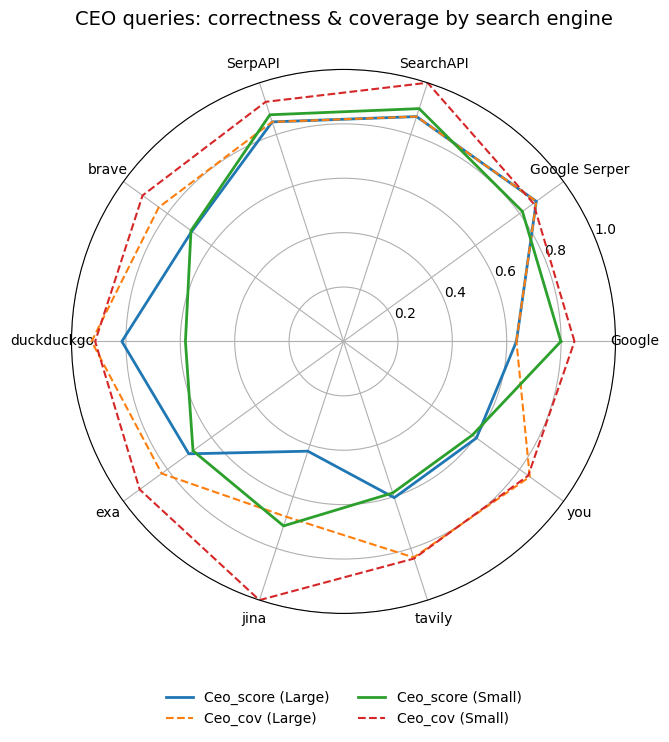

In [14]:
plot_report_radar(
    final,
    score_col="ceo_score",
    coverage_col="ceo_cov",
    title="CEO queries: correctness & coverage by search engine",
)

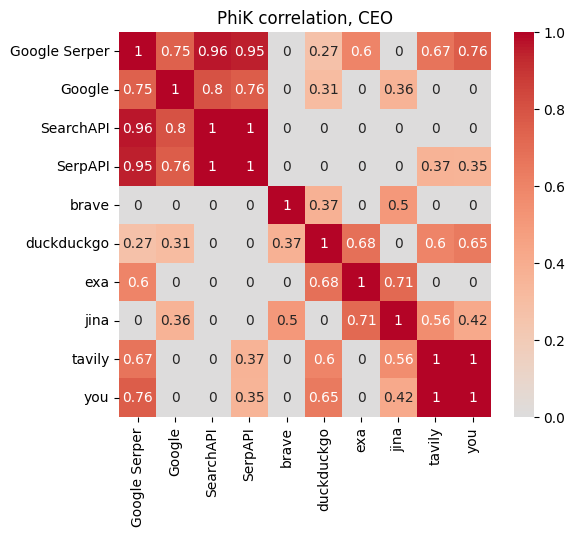

In [15]:
ceo_corr = ceo_cols.phik_matrix(interval_cols=[])

plt.figure(figsize=(6, 5))
sns.heatmap(ceo_corr, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("PhiK correlation, CEO")
plt.show()

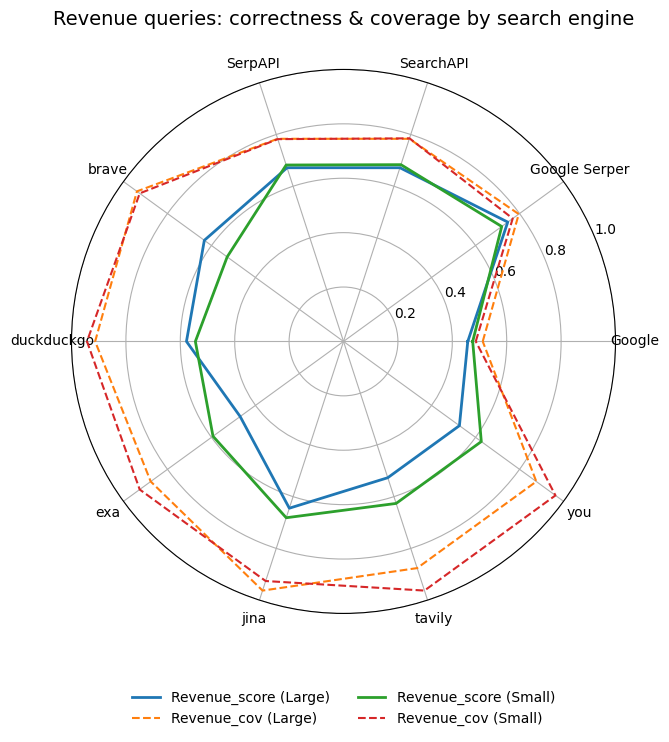

In [20]:
plot_report_radar(
    final,
    score_col="revenue_score",
    coverage_col="revenue_cov",
    title="Revenue queries: correctness & coverage by search engine",
)

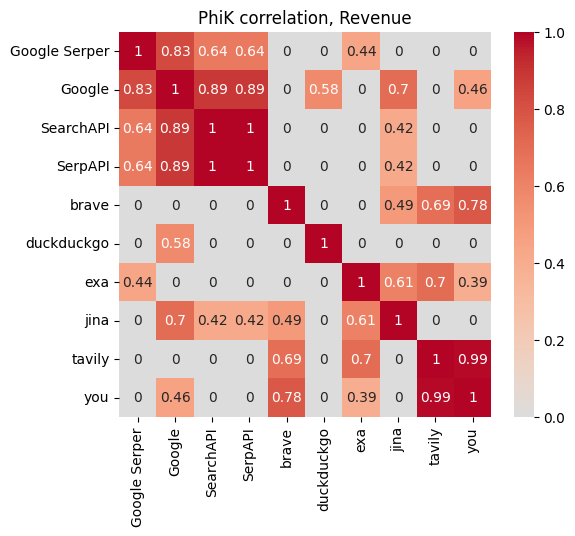

In [21]:
revenue_corr = revenue_cols.phik_matrix(interval_cols=[])

plt.figure(figsize=(6, 5))
sns.heatmap(revenue_corr, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("PhiK correlation, Revenue")
plt.show()

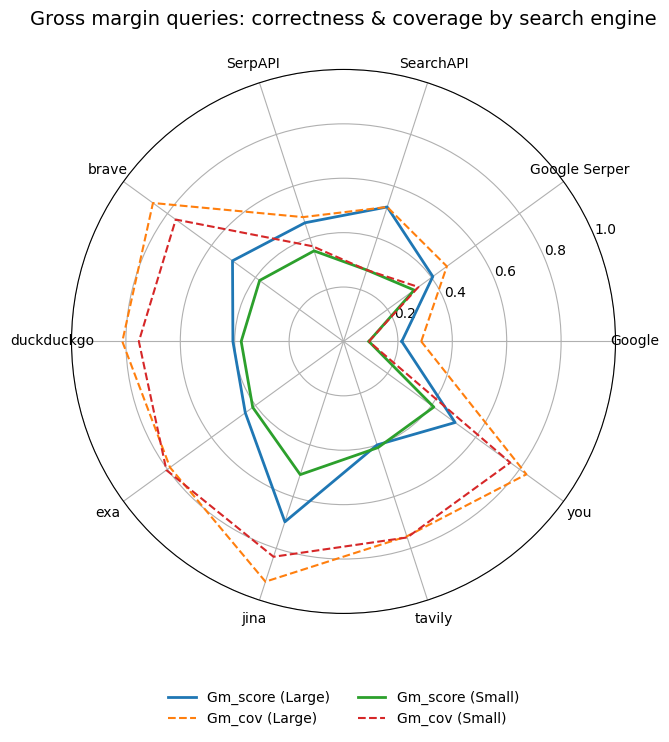

In [22]:
plot_report_radar(
    final,
    score_col="gm_score",
    coverage_col="gm_cov",
    title="Gross margin queries: correctness & coverage by search engine",
)

c:\Users\pavel\Desktop\Bicocca_DS_2026\.venv\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable Google for analysis 1. Dropping this column
  warnings.warn(


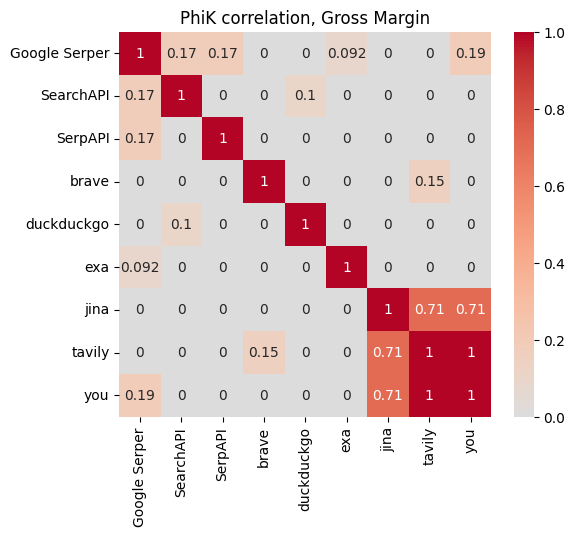

In [23]:
gross_margin_corr = gross_margin_cols.phik_matrix(interval_cols=[])

plt.figure(figsize=(6, 5))
sns.heatmap(gross_margin_corr, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=1)
plt.title("PhiK correlation, Gross Margin")
plt.show()

### Comparison multiagentic approach and simpler GPT Web-Search Tool approach

In [28]:
check_results_multiagentic = pd.read_excel("data/multiagentic_results.xlsx")
check_results_gpt_websearch = pd.read_excel("data/gpt_websearch_results.xlsx")


def compute_accuracy_by_size(df, approach_name):
    result = (
        df.groupby("size")
        .agg(
            ceo_accuracy=("ceo_correctness", "mean"),
            revenue_accuracy=("revenue_correctness", "mean"),
            gross_margin_accuracy=("gross_margin_correctness", "mean"),
        )
        .reset_index()
    )

    result["approach"] = approach_name
    return result


res_a = compute_accuracy_by_size(check_results_multiagentic, "Multiagentic")
res_b = compute_accuracy_by_size(check_results_gpt_websearch, "GPT Web-Search")

final_table = pd.concat([res_a, res_b], ignore_index=True)
cols = ["approach"] + [col for col in final_table.columns if col != "approach"]
final_table = final_table[cols]

final_table

,approach,size,ceo_accuracy,revenue_accuracy,gross_margin_accuracy
0,Multiagentic,large,0.8,0.6,0.285714
1,Multiagentic,small,1.0,1.0,0.2
2,GPT Web-Search,large,1.0,1.0,0.857143
3,GPT Web-Search,small,1.0,1.0,0.7
